# Get the data

In [ ]:
!gdown --id 1HVSazFk8m553VWPjFnZZ-YfJA_KecPea
!unzip translated_data_updated.zip

Downloading...
From: https://drive.google.com/uc?id=1HVSazFk8m553VWPjFnZZ-YfJA_KecPea
To: /content/translated_data_updated.zip
100% 122M/122M [00:00<00:00, 126MB/s]
Archive:  translated_data_updated.zip
   creating: data_translated/
  inflating: data_translated/coupon_visit_train.csv  
  inflating: data_translated/coupon_list_train.csv  
  inflating: data_translated/prefecture_locations.csv  
  inflating: data_translated/coupon_area_test.csv  
  inflating: data_translated/coupon_detail_train.csv  
  inflating: data_translated/coupon_area_train.csv  
  inflating: data_translated/user_list.csv  
  inflating: data_translated/coupon_list_test.csv  


In [ ]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set_theme(context='notebook', style='darkgrid')
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# Important Note:
# Visits = browsing history in the training period. No test set available. 
# Purchases = purchase history in the training period. No test set available.

df_users        = pd.read_csv('data_translated/user_list.csv')
df_c_list_train = pd.read_csv('data_translated/coupon_list_train.csv')
df_c_list_test  = pd.read_csv('data_translated/coupon_list_test.csv')
df_area_train   = pd.read_csv('data_translated/coupon_area_train.csv')
df_area_test    = pd.read_csv('data_translated/coupon_area_test.csv')
df_visit_train  = pd.read_csv('data_translated/coupon_visit_train.csv')
df_purch_train  = pd.read_csv('data_translated/coupon_detail_train.csv')
df_locations    = pd.read_csv('data_translated/prefecture_locations.csv')

## Feature Engineering
#### User List

In [ ]:
# rename SEX_ID column, change to categorical value (0 Male, 1 Female)
df_users['SEX'] = df_users['SEX_ID'].replace('f', 1)
df_users['SEX'] = df_users['SEX'].replace('m', 0)

In [ ]:
# create a categorical variable for age group:
# 14-21, 22-35, 36-49, 50-65, 66-75, 76-90
def age_cat(age):
  if age <= 21:
    return 0
  elif age <= 35:
    return 1
  elif age <= 49:
    return 2
  elif age <= 65:
    return 3
  elif age <= 75:
    return 4
  elif age <= 90:
    return 5
  else:
    return 6

lbl_age_ranges = ['14-21', '22-35', '36-49', '50-65', '66-75', '76-90'] 

df_users['AGE_GROUP'] = [age_cat(a) for a in df_users['AGE']]

#### Data Preparation for Model Training
We will first train a simple model that takes the following features. 
- A denormalized row of users's coupon purchases, including
  - User Gender
  - User Age
  - User Prefecture
  - Coupon Genre
  - Coupon Ken Name (Prefecture)
  - Price Rate
  - Catalog Price
  - Discount Rate
  - Ken Name

This is a model-based hybrid collaborative filtering approach. 

In [ ]:
# Model Input Features
# For each user who purchased a coupon...

# Gender, Age, Prefecture, Coupon Genre, Coupon Prefecture, Price Rate, Catalog Price, Discount Rate, Ken Name

#############################
# BUILD DF_TRAIN DATAFRAME  #
#############################
df_visit_train = df_visit_train.rename(columns={'VIEW_COUPON_ID_hash': 'COUPON_ID_hash'})
df_train = df_visit_train.join(df_users.set_index('USER_ID_hash'), on='USER_ID_hash', lsuffix='_v')
df_train = df_train.join(df_c_list_train.set_index('COUPON_ID_hash'), on='COUPON_ID_hash', rsuffix='_c')

In [ ]:
# get a subset of the training columns and rename them
df_train = df_train[['AGE_GROUP', 'SEX', 'PREF_NAME_EN', 'KEN_NAME_EN', 'GENRE_NAME_EN', 'CAPSULE_TEXT_EN', 'PRICE_RATE', 'DISCOUNT_PRICE', 'PURCHASE_FLG']]
df_train.columns = ['age_group', 'sex', 'user_prefecture', 'coupon_prefecture', 'genre', 'capsule', 'discount_rate', 'discount_price', 'purchased']
# NaN preprocessing
df_train = df_train.fillna(0)

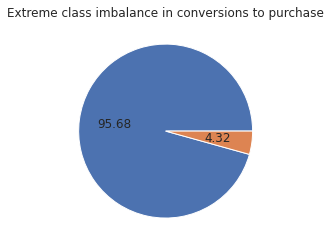

Purchased: 122389 (4.32% of total)
Visited but didn't purchase: 2710791


In [ ]:
stats = df_train.groupby('purchased').size().to_frame().reset_index()
stats.columns = ['purchased', 'count']

fig, ax = plt.subplots()
ax.pie(stats['count'], autopct='%.2f')
plt.title('Extreme class imbalance in conversions to purchase')
plt.show()

pos = stats[stats['purchased'] == 1].agg('sum')['count']
neg = stats[stats['purchased'] == 0].agg('sum')['count']
total = pos + neg
print(f'Purchased: {pos} ({round(pos/total * 100, 2)}% of total)')
print(f"Visited but didn't purchase: {neg}")

In [ ]:
# one-hot encode training data categorical columns 
df_train_enc = pd.get_dummies(df_train, columns=['age_group', 'sex', 'user_prefecture', 'coupon_prefecture', 'genre', 'capsule'])
df_train_enc.head(5)

,discount_rate,discount_price,purchased,age_group_0,age_group_1,age_group_2,age_group_3,age_group_4,age_group_5,sex_0,sex_1,user_prefecture_0,user_prefecture_Aichi Prefecture,user_prefecture_Akita,user_prefecture_Aomori Prefecture,user_prefecture_Chiba Prefecture,user_prefecture_Ehime Prefecture,user_prefecture_Fukui Prefecture,user_prefecture_Fukuoka Prefecture,user_prefecture_Fukushima Prefecture,user_prefecture_Gifu Prefecture,user_prefecture_Gunma Prefecture,user_prefecture_Hiroshima Prefecture,user_prefecture_Hokkaido,user_prefecture_Hyogo Prefecture,user_prefecture_Ibaraki Prefecture,user_prefecture_Ishikawa Prefecture,user_prefecture_Iwate Prefecture,user_prefecture_Kagawa Prefecture,user_prefecture_Kagoshima Prefecture,user_prefecture_Kanagawa Prefecture,user_prefecture_Kochi Prefecture,user_prefecture_Kumamoto Prefecture,user_prefecture_Kyoto,user_prefecture_Mie,user_prefecture_Miyagi Prefecture,user_prefecture_Miyazaki Prefecture,user_prefecture_Nagano Prefecture,user_prefecture_Nagasaki Prefecture,user_prefecture_Nara Prefecture,...,coupon_prefecture_Yamanashi Prefecture,genre_0,genre_Beauty,genre_Class,genre_Delivery service,genre_Gift Card,genre_Gourmet dining,genre_Hair salon,genre_Health and medical,genre_Hotels and inns,genre_Leisure,genre_Nail and eye salon,genre_Other coupons,genre_Relaxation,genre_Spa,capsule_0,capsule_Beauty,capsule_Class,capsule_Correspondence course,capsule_Delivery service,capsule_Event,capsule_Gift card,capsule_Guest house,capsule_Hair salon,capsule_Health / medical,capsule_Hotel,capsule_Japanese guest house,capsule_Japanese inn,capsule_Leisure,capsule_Lesson,capsule_Lodge,capsule_Nail and eye salon,capsule_Other coupon,capsule_Public inn,capsule_Relaxation,capsule_Resort inn,capsule_Restaurant,capsule_Spa,capsule_Vacation rental,capsule_Web service
0,78.0,1575.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,78.0,1575.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,66.0,1480.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,80.0,1990.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,85.0,4980.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Train test split with stratified sampling on the positive class. 
# Make sure each set has the same (though very small) ratio of positive instances
df_training, df_test = train_test_split(df_train_enc, test_size=0.2, stratify=df_train_enc['purchased'])
df_training, df_validation = train_test_split(df_training, test_size=0.2, stratify=df_training['purchased'])

train_labels = np.array(df_training.pop('purchased'))
val_labels = np.array(df_validation.pop('purchased'))
test_labels = np.array(df_test.pop('purchased'))

train_features = np.array(df_training)
val_features = np.array(df_validation)
test_features = np.array(df_test)

In [ ]:
# Normalize the input features using StandardScaler to mitigate class imbalance
# Only *fit* the scaler on the training data, but transform the other two sets.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [ ]:
print(f'Train features shape: {train_features.shape}')
print(f'Validation features shape: {val_features.shape}')
print(f'Test features shape: {test_features.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

print(f'Train columns: {df_training.columns} (len: {len(df_training.columns)}')

Train features shape: (1813235, 145)
Validation features shape: (453309, 145)
Test features shape: (566636, 145)
Train labels shape: (1813235,)
Validation labels shape: (453309,)
Test labels shape: (566636,)
Train columns: Index(['discount_rate', 'discount_price', 'age_group_0', 'age_group_1',
       'age_group_2', 'age_group_3', 'age_group_4', 'age_group_5', 'sex_0',
       'sex_1',
       ...
       'capsule_Lodge', 'capsule_Nail and eye salon', 'capsule_Other coupon',
       'capsule_Public inn', 'capsule_Relaxation', 'capsule_Resort inn',
       'capsule_Restaurant', 'capsule_Spa', 'capsule_Vacation rental',
       'capsule_Web service'],
      dtype='object', length=145) (len: 145


In [ ]:
# Build a binary classification model
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu', 
                         input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
# build the untrained model
EPOCHS = 100
BATCH_SIZE = 2048

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                2336      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# test run with no training - these weights should be unrealistically high
model.predict(train_features[:10])

array([[0.78800064],
       [0.7660615 ],
       [0.7773887 ],
       [0.771608  ],
       [0.80279243],
       [0.72266585],
       [0.66574454],
       [0.4658518 ],
       [0.7539464 ],
       [0.73523104]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss with naive bias initialization: {:0.4f}".format(results[0]))

Loss with naive bias initialization: 1.2691


In [ ]:
# set a slightly smarter initial bias to improve learning
# these weights should be much more reasonable
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.11360571],
       [0.05527395],
       [0.08539504],
       [0.07177296],
       [0.10174784],
       [0.06554922],
       [0.04680771],
       [0.04310331],
       [0.08703664],
       [0.06663606]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss with careful bias init (should be way better): {:0.4f}".format(results[0]))
# save the initial weights for better training
model.save_weights('initial_weights')

Loss with careful bias init (should be way better): 0.1996


In [ ]:
# Compare model losses with and without bias initialization
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
# naive bias @ 20 epochs
model = make_model()
model.load_weights('initial_weights')
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

# careful bias @ 20 epochs
model = make_model()
model.load_weights('initial_weights')
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

NameError: ignored

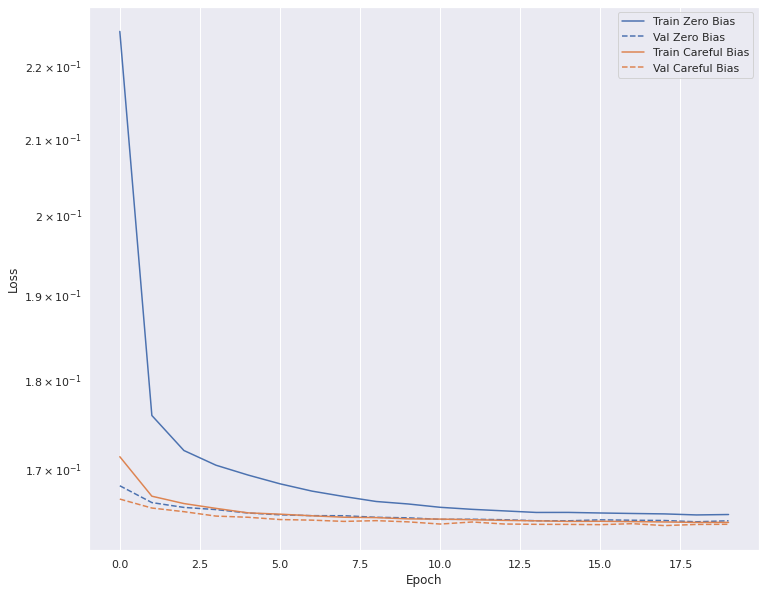

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
# Weight the classes, so the model pays more attention to purchases
weight_neg = (1 / neg) * (total / 2.0)
weight_pos = (1 / pos) * (total / 2.0)

class_weight = {0: weight_neg, 1: weight_pos}

print('Weight for class 0: {:.2f}'.format(weight_neg))
print('Weight for class 1: {:.2f}'.format(weight_pos))

Weight for class 0: 0.52
Weight for class 1: 11.57


In [ ]:
# Train the final model with early stopping, class weights, initial bias weights

weighted_model = make_model()
weighted_model.load_weights('initial_weights')

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
886/886 [==============================] - 13s 12ms/step - loss: 0.7300 - precision: 0.0633 - tp: 38988.0000 - fp: 577235.0000 - tn: 1591398.0000 - fn: 58923.0000 - accuracy: 0.7193 - recall: 0.3982 - auc: 0.5990 - prc: 0.0621 - val_loss: 0.5554 - val_precision: 0.0764 - val_tp: 11312.0000 - val_fp: 136729.0000 - val_tn: 296998.0000 - val_fn: 8270.0000 - val_accuracy: 0.6801 - val_recall: 0.5777 - val_auc: 0.6955 - val_prc: 0.0908
Epoch 2/100
886/886 [==============================] - 9s 10ms/step - loss: 0.6529 - precision: 0.0663 - tp: 45560.0000 - fp: 641264.0000 - tn: 1093642.0000 - fn: 32769.0000 - accuracy: 0.6283 - recall: 0.5816 - auc: 0.6608 - prc: 0.0748 - val_loss: 0.5527 - val_precision: 0.0774 - val_tp: 11484.0000 - val_fp: 136979.0000 - val_tn: 296748.0000 - val_fn: 8098.0000 - val_accuracy: 0.6800 - val_recall: 0.5865 - val_auc: 0.7001 - val_prc: 0.0941
Epoch 3/100
886/886 [==============================] - 8s 9ms/step - loss: 0.6347 - precision: 0.0685 - tp:

#### Mapping coupon predictions to users and packaging the submission

In [ ]:
# generate a row containing user metadata with a test coupon
def get_test_row(user, coupon):
  age_group         = user.AGE_GROUP
  sex               = user.SEX
  user_prefecture   = user.PREF_NAME_EN
  coupon_prefecture = coupon.KEN_NAME_EN
  genre             = coupon.GENRE_NAME_EN
  capsule           = coupon.CAPSULE_TEXT_EN
  discount_rate     = coupon.PRICE_RATE
  discount_price    = coupon.DISCOUNT_PRICE

  row = [age_group, sex, user_prefecture, coupon_prefecture, genre, capsule,
         discount_rate, discount_price]

  return row

In [ ]:
# Use the model to predict 10 coupons for every single user
from tqdm import tqdm # this will take a while

df_join_users = df_users.fillna(0)

results = []
for i, u in tqdm(df_join_users.iterrows(), total=df_join_users.shape[0]):
  coupon_rows = []
  coupon_ids = []
  for j, c in df_c_list_test.iterrows():
    coupon_rows.append(get_test_row(u, c))
    coupon_ids.append(c.COUPON_ID_hash)
  
  df_user_recommended = pd.DataFrame(coupon_rows)
  df_user_recommended.columns = ['age_group', 'sex', 'user_prefecture', 'coupon_prefecture', 'genre', 'capsule', 'discount_rate', 'discount_price']
  df_user_recommended.fillna(0)

  # one-hot encode the categorical test data columns
  coupon_rows = pd.get_dummies(df_user_recommended, columns=['age_group', 'sex', 'user_prefecture', 'coupon_prefecture', 'genre', 'capsule'])
  coupon_rows = coupon_rows.reindex(columns=df_training.columns, fill_value=0)
  coupon_rows = np.array(coupon_rows)
  coupon_rows = scaler.fit_transform(coupon_rows)

  # predict
  preds = model.predict(coupon_rows)
  preds = preds.flatten()

  df_predictions = pd.DataFrame(zip(coupon_ids, preds), columns=['coupon', 'likelihood'])
  df_predictions = df_predictions.sort_values(by='likelihood', ascending=False)
  df_predictions = df_predictions.head(10)
  ten_coupon_string = ' '.join(df_predictions['coupon']).strip()
  results.append({'USER_ID_hash': u.USER_ID_hash, 'PURCHASED_COUPONS': ten_coupon_string})

df_submission = pd.DataFrame(results)

  0%|          | 0/22873 [00:00<?, ?it/s]

100%|██████████| 22873/22873 [56:23<00:00,  6.76it/s]


In [ ]:
df_submission.info()
df_submission.to_csv('submission.csv', header=True, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22873 entries, 0 to 22872
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   USER_ID_hash       22873 non-null  object
 1   PURCHASED_COUPONS  22873 non-null  object
dtypes: object(2)
memory usage: 357.5+ KB


In [ ]:
model.save('bruteforce_weighted_log_reg_model.pb')

INFO:tensorflow:Assets written to: bruteforce_weighted_log_reg_model.pb/assets


In [ ]:
!zip bruteforce_weighted_log_reg_model.zip bruteforce_weighted_log_reg_model.pb/

  adding: bruteforce_weighted_log_reg_model.pb/ (stored 0%)
